# Pairs Trading using Reinforcement Learning - Stock Trading using Actor Critic Model

**Unit:** Artificial Intelligence CITS4404 <br>
**Lecturer:** Dr Yuliya Karpievitch <br>
**Date:** 24th October 2019

**Group members:** <br>
Madeleine Lim 21708238 <br>
Robin Markwitz 21968594 <br>
Ruan Scheepers 21980258 <br>
Asaf Silman    21985278


In order to use this notebook, the python package `alpha-vantage` must be installed.
Run the below cell to install this package.

In [ ]:
!pip install alpha-vantage

In order to use this notebook, the python package `gym` must be installed.
Run the below cell to install this package.

In [ ]:
!pip install gym

In [1]:
#imports
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

#for the trading environment
import gym
from gym import error, spaces, utils
from gym.utils import seeding

#for the models
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.backend as K
import tensorflow.keras.losses as kls

from src.gym_pairs_trading import PairsTradingEnv

TensorFlow 2.0 mus

In [2]:
print(tf.__version__)

2.0.0


## 1. Introduction
***Pairs trading*** is a trading strategy which identifies a pair of stocks which exhibit similar price movements in order to exploit financial markets that are out of equilibrium. The pair of stocks are of similar company size and within similar industry sectors. The strategy ustilises the *spread* of the pair, which is the difference between the normalised log prices.

***Reinforcement learning*** is machine learning (ML) method that involves an agent which can perform some actions within an environment. The model learns about its environment through discovery of which actions to take in certain situations. It can be rewarded or penalised based on the task goal. We will be using the actor-critic (AC) reinforcement learning method.

***Actor-Critic model***  is a ML method with two models - the Actor and the Critic. The Actor will perform an action which affects the environment. Then the Critic judges the effect of this action on the environment. The Critic must teach the Actor to make better decisions given the state of the environment.

### 1.1 Project strategy

This project aims to implement the AC model in order to increase its portfolio value based on the pairs trading strategy. 

The Actor takes in observations, such as stock price changes, the spread between pairs, and if it is currently holding any stock (i.e. whether it is in the spread). Based on these observations the model maps a probability distribution of which action it should take of three:
* Buy - Buying stock with all cash balance
* Sell - Selling all stock
* Hold - No action taken

Buying in this case means to place a bet that the prices will converge. Selling signifies closing the bet, and taking any profits. Based on which action is taken, the environment assigns a reward to the action. We used the portfolio percent change in net asset value (NAV) as the reward.

The Critic takes the same observations as the actor, but outputs an estimated reward. In this way the Critic helps to train the actor to make good choices.


The data used for training are the Apple and Microsoft stock data, which are in simlar industry sectors. The environment is created using `gym` which is a library commonly used for Reinforcement Learning tasks. The model is compared to a random strategy model over the same time frame which can be run within this notebook. The model itself is implemented within this notebook following the random strategy model.

## 2. Data

This project sources stock data from `alpha_vantage`. The `data_source.py` file contained within the environment source files implement this. Below is an exmaple of the data cleaning process and some examples of the stock data prices over time.

### 2.1 Demo code for loading Alpha Vantage data

First we create a `DataSource` and `MarketMetrics` instance which will help retreving data efficiently, and calculate metrics from the data.

For this example we used Apple (AAPL) and Microsoft (MSFT) for pairs trading. but any valid stock code can be submitted.

For the demo only a subset of the data is retrieved, specifing `size='full'` will download the whole dataset.
The normalisation window we used was 20 days , this is close to a months worth of trading days, and we felt this was a suitable window for the task. However this can also be changed to a higher/lower window.

In [3]:
from src.gym_pairs_trading.envs.data_source import DataSource
from src.gym_pairs_trading.envs.market_metrics import MarketMetrics

# Create a data instance
STOCK_1_SYMBOL = "AAPL" # Apple stock symbol
STOCK_2_SYMBOL = "MSFT" # Microsoft stock symbol, can be any stock symbol such as amazon (AMZM)

ds = DataSource(STOCK_1_SYMBOL, STOCK_2_SYMBOL, size='compact')
mm = MarketMetrics(window_size=20)

Now that the we have a datasource and metric instance ready, we can initialise a list for the prices and spread values

In [4]:
stock_1_prices = []
stock_2_prices = []
stock_prices_spread = []

Iterate though datasource, and calculate the spread. For the first `window_size` days the spread will be invalid, because ther is not enough data to calculate the normalised price. These days will be set to 0.

In [5]:
mm.reset()

for _, data in ds:
    stock_1_price = data[0]
    stock_2_price = data[1]
    
    spread, ready = mm.update(stock_1_price, stock_2_price)
    if ready:
        stock_prices_spread.append(spread)
    else:
        stock_prices_spread.append(0)
    stock_1_prices.append(stock_1_price)
    stock_2_prices.append(stock_2_price)

Plot the raw stock prices of stock 1 and stock 2

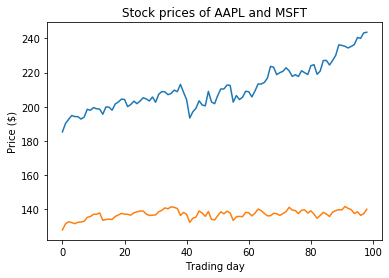

In [6]:
plt.plot(stock_1_prices)
plt.plot(stock_2_prices)
plt.title(f"Stock prices of {STOCK_1_SYMBOL} and {STOCK_2_SYMBOL}")
plt.ylabel("Price ($)")
plt.xlabel("Trading day")

plt.show()

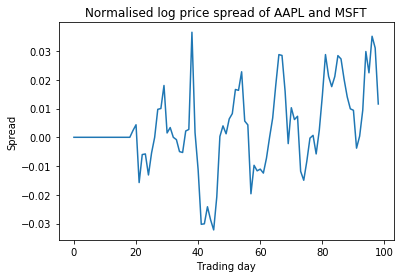

In [7]:
plt.plot(stock_prices_spread)
plt.title(f"Normalised log price spread of {STOCK_1_SYMBOL} and {STOCK_2_SYMBOL}")
plt.ylabel("Spread")
plt.xlabel("Trading day")

plt.show()

## 3. Environment

The environment was implemented with the `gym` library which requires a specific directory structure for the `env` source files. There are four scripts which make up the environment for this project:

`data_source.py` - Loads the pair of stock data in. Need to find the minimum starting date of each stock to only use intersection of stock data. The main purpose of this script is to return a data point, which consists of *[s1 close, s2 close, s1 pct, s2 pct]*. We choose to get percentage change rather than absolute value because stock prices are not normalised.

`market_metrics.py` - Converts stock data into observable values, and calculates the spread of the pair of stock data. We set a window size of 20 days (which is what 2 weeks worth of working days amounts to) so we can normalise that prices in order to calculate the spread.

`trading_sim.py` - Applies the actions chosen by the Actor to the environment. Responsible for accounting stock balances and cash balances, and executing trades and rules. It calculates the net asset value of the portfolio. 

`pairs_trading_env.py` - Implements the gym interface in order to initialise the environment.


### 3.1 A note on data_source.py

Some companies sometimes do a stock split, where a company intentinally dilutes the stock supply to reduce the price, for example a 2-1 split where each share holder gets 2 shares for every 1 share the held before the split. This sometimes happens to make the stock price more accessible to investors, hopefully increasing their liquidity. To account for this the price of each stock will be multiplied by the split factor to normalise the stock price. This logic is built into the `data_source.py` file and eliminates dramatic declines in stock prices that are associated with a stock split.

### Initialize PairsTradingEnv for Model v1
The following cell loads the environment with two stocks: Apple (through its stock symbol AAPL)
and Microsoft (through its stock symbol MSFT). These two stocks trade in the same industry and hence are suitable for pairs trading. The docstring for `__init__` is provided:

```python
"""Initializes the PairsTradingEnv.

    Arguments:
        data_1 {str} -- the stock symbol for Stock 1
        data_2 {str} -- the stock symbol for Stock 2
        days {int} -- the number of days to consider in the observation
            space
        spread_status {int} -- if the spread status is considered or not.

        Example:
                spread_status = 0 : the status is not considered
                spread_status = 1 : the status is considered
                spread_status = 2 : the spread status is considered, including if
                    spread value inverts since buying
                Other values are not legal.

    Key Word Arguments:
        None
"""
```

For Model v1, it only considers **1 day** of past stock data, and the spread status is **not considered**.
Hence `days = 1` and `with_status = 0`.

In [8]:
env = PairsTradingEnv("AAPL","MSFT", 1, 0)
print(env.observation_space.shape)

(3,)


## 4. Random strategy

The benchmark of the project was a random strategy of randomly buying, selling or holding. This strategy had trading rules hardcoded to prevent illegal moves. The AC model did not have trading rules encoded in order to encourage it to learn these rules, by punishing illegal moves with fines. 

You can view the random strategy below.

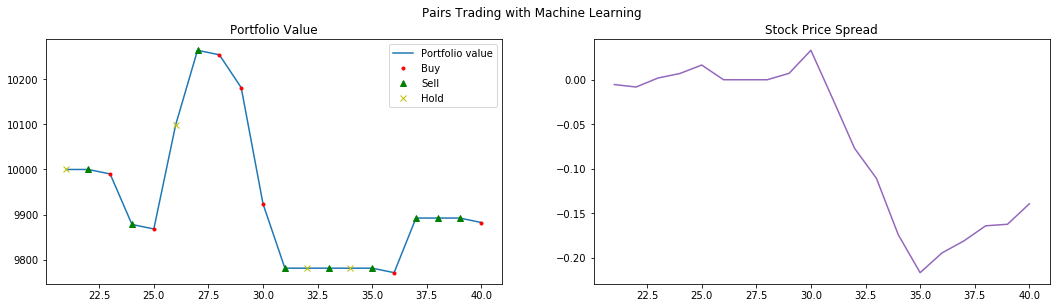

In [9]:
n_iterations = 20 # pick an arbitrary length of time

obs = env.reset() # reset the environment
for ii in range(n_iterations):
    action = np.random.choice([0,1,2]) # choose a random action, where 0 = buy, 1 = sell, 2 = hold
    obs, reward, done, msg = env.step(action, 1.0) # perform 1 iteration of the environment

env.render() # provide a visual view of the actions taken in the environment

## 5. Models

This model is a combination of two sequential models: the `Actor` model and the `Critic` model. The `Actor` considers the observation space defined by the environment and based on this, returns a probability distribution from which an action is randomly chosen. The `Critic` also considers the observation space and returns an estimation of the reward of the current state of the environment. The difference between the `Critic`'s reward function and the internal environment reward function is known as an Advantage, and is used in order to train the model. This method is known as the "Advantage Actor-Critic" method and has become very popular when employing reinforcement learning algorithms.
Inspiration for the model structure was obtained from:

<a href="http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/
">Roman Ring's Deep Reinforcement Learning implementation using TensorFlow 2.0</a>

<a href="https://towardsdatascience.com/a-blundering-guide-to-making-a-deep-actor-critic-bot-for-stock-trading-c3591f7e29c2
">Tom Grek's blundering guide to making a deep actor-critic bot for stock trading</a>


### Models

The `Actor` model is a sequential, multi-layered network with two dense layers and an output layer using the `softmax` activation function in order to return a probability distribution (calculated from logits). The loss function used is `SparseCategoricalCrossentropy`. This was chosen since the `Actor` model works with probability distributions, and the aforementioned advantages are a metric that is used in order to determine the overall effect of actions taken. 

The `Critic` model is also a sequential, multi-layered network using only `relu` activation functions. The loss function is `mse`. 

### Training 
Training is performed on batches, since we want to consider a larger sample of data in order for the model to learn from the result of a select number of actions over a short period of time, instead of one particular action on one day. However training it over the entire data set destroys the effect that one action has on the environment, hence batch training is preferred. 
Action distributions are multiplied by the advantages returned through the `Critic`'s estimation of the reward. Hence the `Actor` is trained by the `Critic`.

## 5.1 Model v1 setup

Provided is the ActorCriticV1 model. This model was an initial attempt to simulate pairs trading using the Actor-Critic infrastructure.

In [10]:
from tensorflow.keras.models import Sequential, Model

class ActorCritic_V1(object):
    """ActorCritic model for continous observation space, and discrete action space
    
    Arguments:
        object {PairsTradingEnv} -- the pairs trading environment.
    
    Returns:
        model {ActorCritic_V1} -- the Keras model.
    """
    def __init__(self, env, **kwargs):
        """Initializes the model.
        
        Arguments:
            env {PairsTradingEnv} -- the pairs trading environment.
        
        Key Word Arguments:
            learning_rate {float} -- the learning rate.
        """
        self.env=env

        self.learning_rate = kwargs.get('learning_rate', 0.001)
    
        self.saved_actions = [] # history of actions taken by the model. used in the actor loss
        self.saved_values = [] # history of rewards estimated by the Critic. used in the critic loss
        self.rewards = [] # history of rewards that the env calculated
        
        self.actor_model  = self._create_actor_model() # initializes the Actor model
        self.critic_model = self._create_critic_model() # initializes the Critic model

    def _create_actor_model(self):
        """Initializes the actor model.
        
        Returns:
            model {tf.keras.Sequential} -- the Actor model.
        """
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(self.env.action_space.n, activation='softmax', name='policy_logits')
        ])
        # use Adam optimizer with a given learning rate
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss=self._actor_loss(), optimizer=opt)
        return model

    def _create_critic_model(self):
        """Initializes the critic model.
        
        Returns:
            model {tf.keras.Sequential} -- the Critic model.
        """
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(1, activation='relu')
        ])
        # use Adam optimizer with a given learning rate
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss="mse", optimizer=opt)

        return model
    
    
    def evaluate_loss_actor(self, y_true, y_pred):
        """A custom loss function to evaluate loss for the actor.
        
        Arguments:
            y_true {list} -- the true label, in which the advantages and actions are embedded.
            y_pred {list} -- the model's predicted label.
        
        Returns:
            loss {Tensor} -- the actor's loss.
        """
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=False) # choice of loss function
        advantages = y_true[:,0] # the advantages are embedded in the first column of y_true
        actions = tf.cast(y_true[:,1], tf.int32) # the actions are embedded in the second column of y_true
        loss = weighted_sparse_ce(actions, y_pred, sample_weight = advantages) # the loss is calculated
        return loss
    
    
    def _actor_loss(self):
        """A wrapper for the custom loss function for the actor.
        
        Returns:
            loss {Function} -- the custom loss function.
        """
        def loss(y_true,y_pred):
            return self.evaluate_loss_actor(y_true, y_pred) # returns the custom loss function defined above
        return loss

    
    def train(self, obs_history):
        """The training loop for both the Actor and the Critic model.
        
        Arguments:
            obs_history {list} -- a list of observations for the required batch size.
        """
        advantages = np.array(self.rewards) - np.array(self.saved_values)
        # calculate the advantages from the actual rewards and the Critic's estimation of the reward
        y_label = []
        for adv, action in zip(advantages, np.array(self.saved_actions)):
            # construct the y label in the following format:
            # [advantage estimated, action taken, 0]
            # where action is either {0 = Buy, 1 = Sell, 2 = Hold}
            y_label.append([adv,action,0])
        
        y_label = np.array(y_label)
        # train the Actor on the observation history and all y labels
        self.actor_model.train_on_batch(np.array(obs_history), y_label)
        # train the Critic on the observation history and all rewards
        self.critic_model.train_on_batch(np.array(obs_history), self.rewards)
    
    
    def eval_state(self, obs):
        """Perform a prediction of the current state with the Critic.
        
        Arguments:
            obs {list} -- the current observation from the environment.
            
        Returns:
            estimated_reward {float} -- the reward of the current state that the Critic estimates.
        """
        return self.critic_model.predict(obs[None, :]) 
    
    
    def predict_action(self, obs):
        """Perform a prediction of the current state with the Actor.
        
        Arguments:
            obs {list} -- the current observation from the environment.
            
        Returns:
            probabilities {list} -- a probability distribution corresponding to the likelihood
            that each action should be selected.
            Example:
                [0.4, 0.5, 0.1]
                corresponds to:
                Choose action 0 (Buy) with probability 0.4
                Choose action 1 (Sell) with probability 0.5
                Choose action 2 (Hold) with probability 0.1
            Note that probabilities[0] is returned in order to reshape the network output.
                
        """
        # Logits are returned when a prediction is made.
        probabilities = self.actor_model.predict(obs[None, :])
        return probabilities[0]
    
    
    def predict(self,obs):
        """Perform a prediction of both models. This is possible since both models take in the observation
        space in the input layer.
        
        Arguments:
            obs {list} -- the current observation from the environment.
        
        Returns:
            (estimated_reward {int}, probabilities {list}) -- estimated reward, and estimated distribution.
        """
        return self.eval_state(obs), self.predict_action(obs)
    
    
    def reset(self):
        """Reset all data used in a training batch."""
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []

### Create the ActorCritic V1 model

In the cell below, the first version of the model is created.
The type is printed to ensure that this is indeed the correct model.

In [11]:
model_v1 = ActorCritic_V1(env)
type(model_v1) is ActorCritic_V1

True

## Train a model

This cell runs a model for a desired amount of time and then this batch of observations is trained on.
After each epoch, the environment is rendered, producing a view of the behaviour of the model.

In [12]:
def trainModel(num_batches, batch_size, num_epochs, penalty, env, model):
    """Trains the model.
    
    Arguments:
        num_batches {int} -- The number of training batches to be considered per epoch.
        batch_size {int} -- The size of each training batch.
        num_epochs {int} -- The number of epochs to be considered.
        penalty {float} -- The penalty to impose on illegal moves.
        env {PairsTradingEnv} -- The environment to be used in this training phase.
        model {ActorCritic_V*} -- The model to be trained.
         
        Example:
            trainModel(5, 30, 10):
            There are 5 batches of size 30 that will be used for 10 training epochs.
            
    """
    
    # changes the starting point if this function is ran for subsequent times
    offset = np.random.randint(0,num_batches*batch_size*0.5);
    
    for epoch in range(num_epochs):
        obs = env.reset() # reset the environment
        env.skip_forward(offset)
        obs, reward, done, msg = env.step(2, 1)
        obs_history = [] # reset the observation history
        model.reset() # reset the model 
        reward = 0 # reset reward
        done = False
        for batch in range(num_batches):
            model.reset() # reset model
            counter = 0 # reset counter
            obs_history = []
            while not done and counter < batch_size:
                state_value, actionProb = model.predict(obs) # perform one prediction for the actor and the critic
                action = np.random.choice([0,1,2], p=actionProb) # choose the action based on the distribution
                
                # advance one step and return a new observation, reward
                if type(model) == ActorCritic_V1:
                    obs, reward, done, msg = env.step(action, penalty) 
                
                elif type(model) == ActorCritic_V3:
                    if obs[len(obs)-2] == 0 and action == 0:
                        model.penalty.append(penalty) # penalise for a false move
                    elif obs[len(obs)-2] == 1 and action == 1:
                        model.penalty.append(penalty) # penalise for a false move
                    elif obs[len(obs)-2] == 1 and action == 0:
                        model.penalty.append(-0.2*penalty) #reward buying into the stock
                    else:
                        model.penalty.append(0)
                    
                    obs, reward, done, msg = env.step(action, 1.0) 
                
                # add variables to history lists
                obs_history.append(obs[None, :][0])
                model.saved_actions.append(action)
                model.saved_values.append(state_value[0][0])
                model.rewards.append(reward)
                if done:
                    break
                counter+=1
                
            # train on the observation history
            model.train(obs_history)
            
        # render the environment after each 3 epochs
        if epoch % 3 == 0:
            env.render()

### Test a model against the random strategy

This cell performs a test of a desired, trained model against a random strategy.
The random strategy has the following behaviour:

```python
if in_the_spread:
    random_choice(sell, hold, [0.5, 0.5])
    
else:
    random_choice(buy, hold, [0.5, 0.5])
```    


This means that the random strategy can only choose between legal moves. 

Tests are performed `num_runs` times, for a length of `length_run`. The starting day can be
provided by `start_day`.


In [13]:
def testModel(num_runs, length_run, start_day, envModel, envRandom, model):
    """Performs a test of the desired model against a random run.
    
    Arguments:
        num_runs {int} -- The number of times for a test to be run.
        length_run {int} -- The length of the test run.
        start_day {int} -- The day on which to start the test. Tests must be performed on unseen
            data, hence the test must be started on the correct day.
            
            Example:
                min_start_day = batch_size * num_batches + 1
                This is the default value that will be set when calling the function.
        env_model {PairsTradingEnv} -- The environment instance that the model will use.
        env_random {PairsTradingEnv} -- The environment instance that the random will use.
        model {ActorCritic_V*} -- The model to be tested.
    
    """
    
    ModelValue = envModel.trading_sim.balance # get balance of model
    RandomValue = envRandom.trading_sim.balance # get balance of random strategy
    
    
    ModelRewards = []
    RandomRewards = []
    
    for run in range(num_runs):
        obsModel = envModel.reset() # reset env
        obsRandom = envRandom.reset() # reset env
        
        # use a random skip in order to provide it with a random piece of the time series
        randomSkip = np.random.randint(0,30) 
        
        envModel.skip_forward(start_day + randomSkip)
        envRandom.skip_forward(start_day + randomSkip)
        
        # advance the model and random environment
        obsModel, reward, done, msg = envModel.step(2, 1.0)
        obsRandom, r, d, msg = envRandom.step(2, 1.0)
        
        # this sequence is similar to the sequence in the trainModel function
        for days in range(length_run):
            state_value, actionProb = model.predict(obsModel)
            action = np.random.choice([0,1,2], p=actionProb)
        
            # we want to impose no penalty when testing
            obsModel, reward, done, msg = envModel.step(action, 1.0)
            
            # update the balance of the model based on the reward
            ModelValue = envModel.get_portfolio_value()
            
            # perform the random strategy   
            if obsRandom[len(obsRandom)-1] == 0:
                action_rand = np.random.choice([1,2])
            else:
                action_rand = np.random.choice([0,2])
        
            # we want to impose no penalty when testing
            obsRandom, r, done, msg = envRandom.step(action_rand, 1.0)
            
            # update the balance of the random strategy based on the reward
            RandomValue = envRandom.get_portfolio_value()
            
        ModelRewards.append(ModelValue)
        RandomRewards.append(RandomValue)
        
        if run % 5 == 0:
            # render the model's environment
            envModel.render()

            # render the random strategy's environment
            envRandom.render()
     
    # return the mean reward over the test iterations for a representative final portfolio value
    return (np.mean(ModelRewards), np.mean(RandomRewards)) 

### Model 1 training
This performs training for 10 epochs on 10 batches of size 10 for Version 1 of the model.

The `Actor` seems to not be significantly changing its distribution, leading to a large element of randomness.

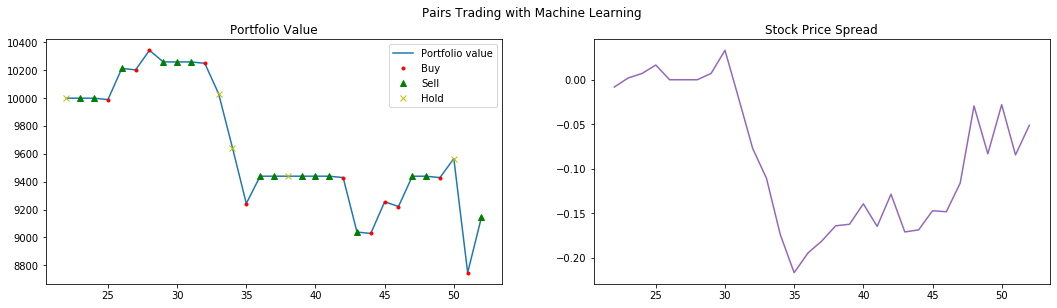

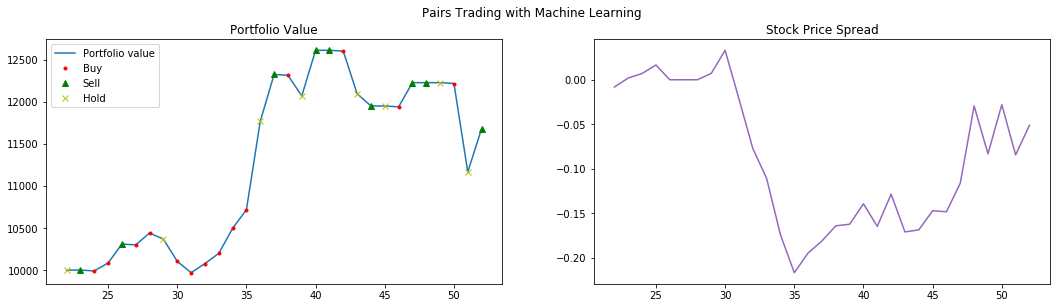

KeyboardInterrupt: 

In [15]:
num_batches = np.random.randint(5, 15) # random number of batches
batch_size = np.random.randint(5, 15) # random batch size
num_epochs = 19 # 10 epochs to be used
penalty = 1.0 # we do not penalize illegal moves

trainModel(num_batches, batch_size, num_epochs, penalty, env, model_v1)

### Model 1 testing

Initially, parameters for testing are set, as well as the environments.
Then, testing is performed against the random strategy.

In [16]:
num_runs = 30 # the test will be run 20 times
length_run = 20 # the test will go over 20 days
start_day = num_batches * batch_size + 1 # the test will start at least 1 day after all training data

In [23]:
env_model = PairsTradingEnv("AAPL", "MSFT", 1, 0)
env_random = PairsTradingEnv("AAPL","MSFT", 1, 0)

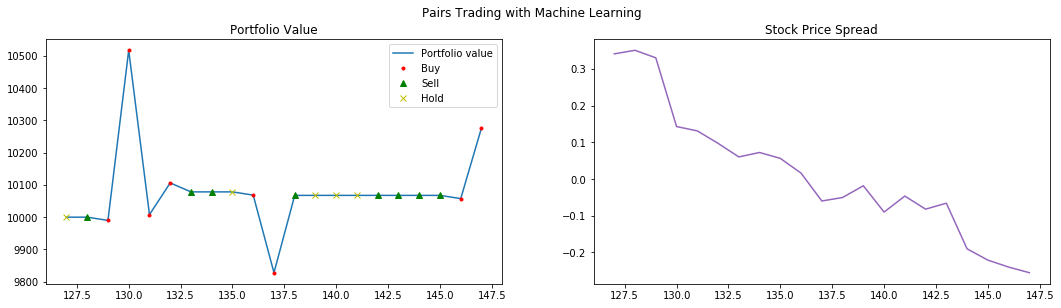

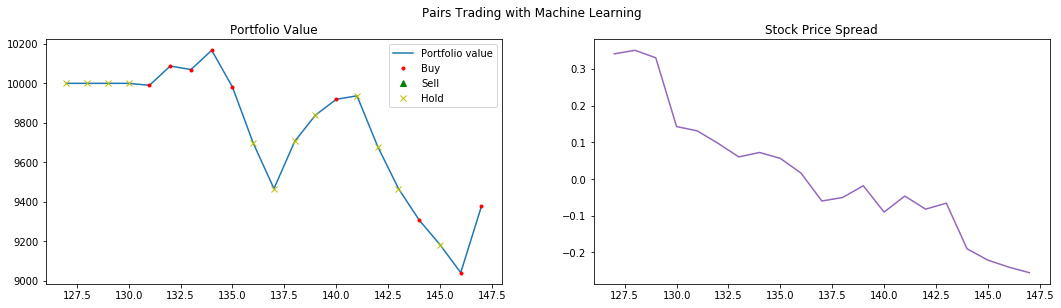

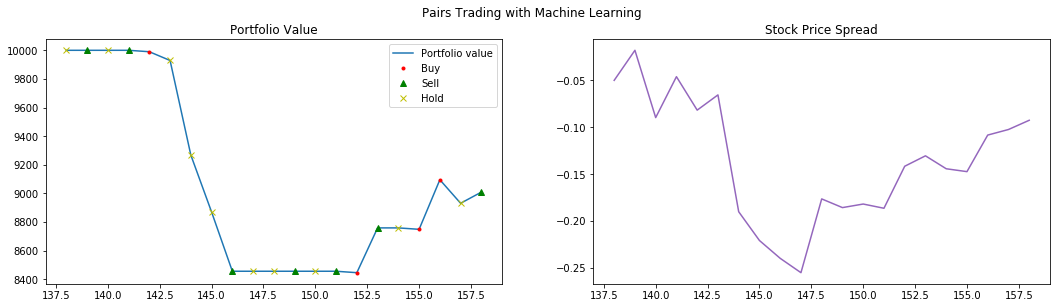

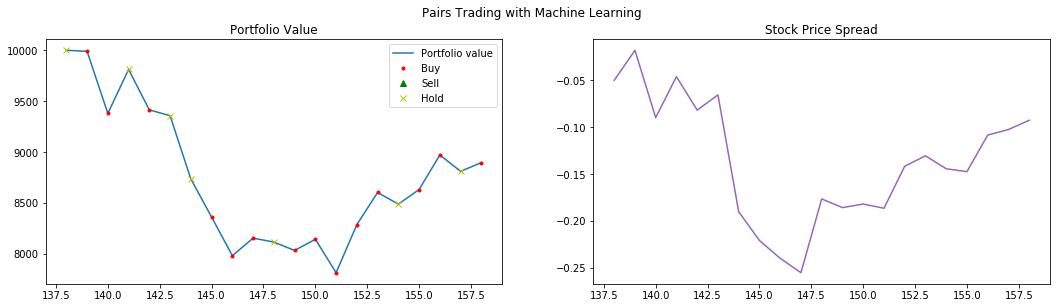

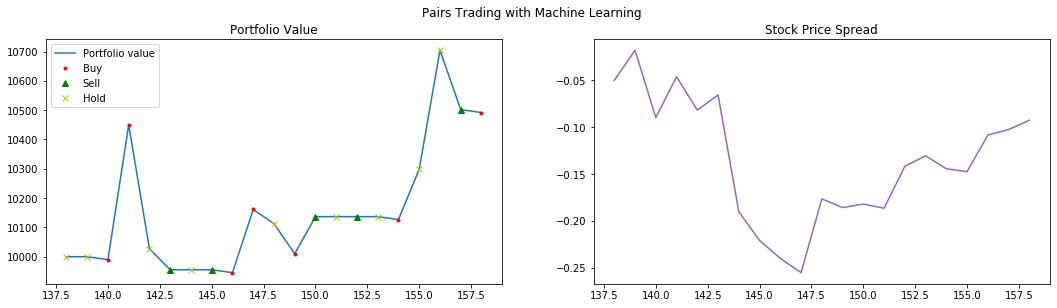

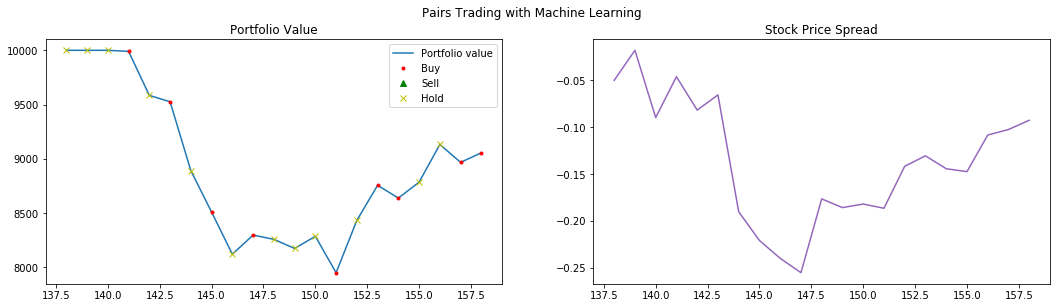

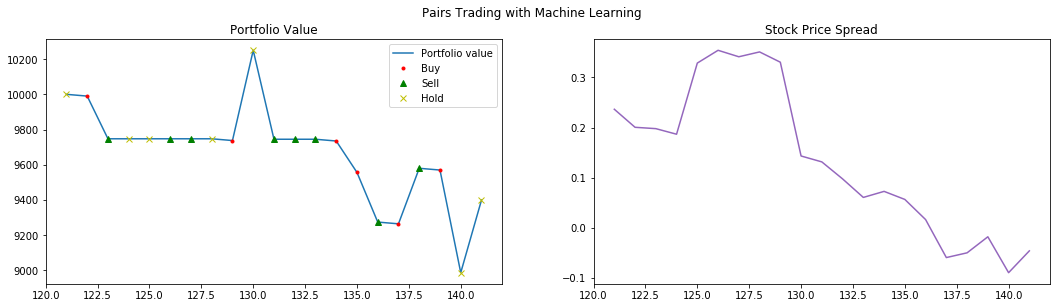

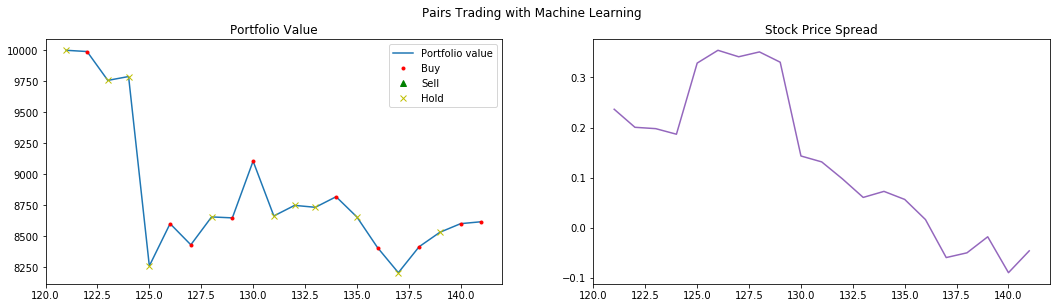

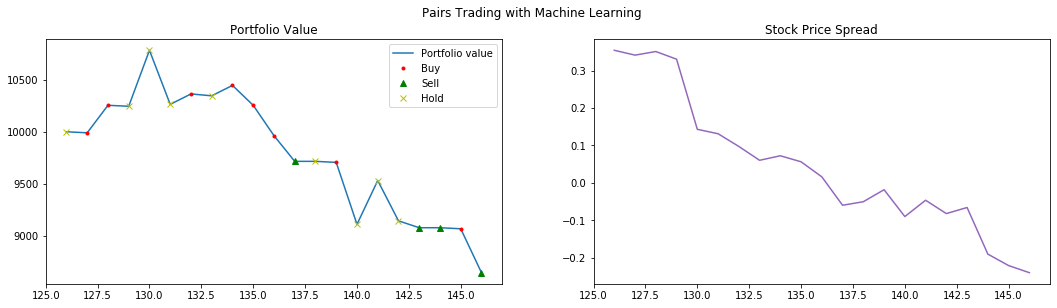

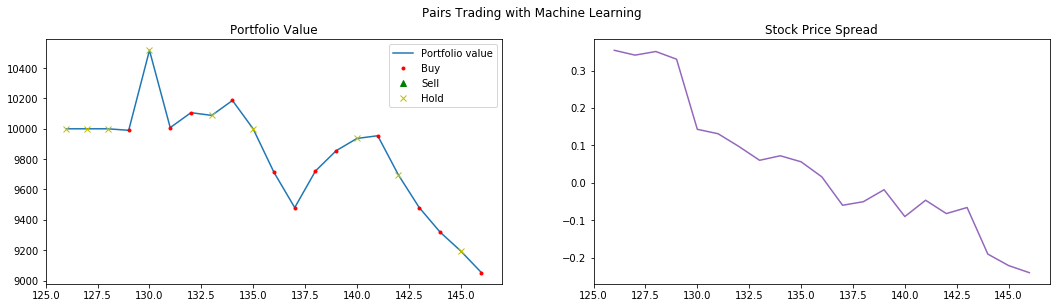

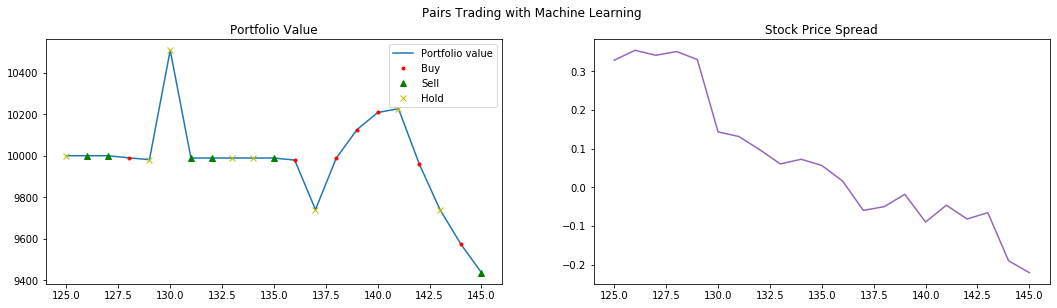

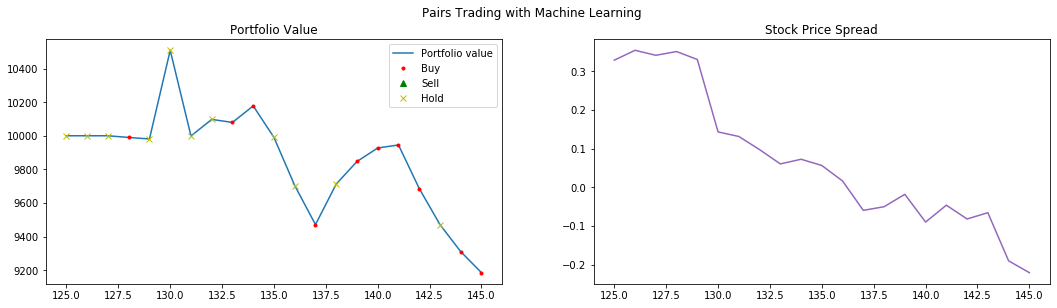

Model has: $8953.8241
Random Agent has: $8825.524633333333

Model has: $128.29946666666729 more than the Random Agent.


In [24]:
(model_reward, random_reward) = testModel(num_runs, length_run, start_day, env_model, env_random, model_v1)
print("Model has: $" + str(model_reward))
print("Random Agent has: $" + str(random_reward))
print()
print("Model has: $" + str(model_reward - random_reward) + " more than the Random Agent.")

## Results For Model 1

When running the test 30 times:

Model has: 8953.8241 dollars

Random Agent has: 8825.524633333333 dollars

Model has: 128.29946666666729 dollars more than the Random Agent.

<a><img src=https://i.kym-cdn.com/entries/icons/original/000/029/959/Screen_Shot_2019-06-05_at_1.26.32_PM.jpg></a>

However, it may be possible to do better. Hence, Model 2 is introduced, with a different observation space and new features.

## Model 2

Model 2 is the exact same as Model 1, however we wish to penalize illegal moves. In this case, we gave it a punishment of 10% of its current portfolio value if it:

- Sells, without it having previously been in the spread
- Buys, when it is already in the spread

Additionally, the observation space is increased to size 4 (from 3). This includes the spread status.

In [10]:
env2 = PairsTradingEnv("AAPL", "MSFT", 1, 1)
print(env2.observation_space.shape)

model_v2 = ActorCritic_V1(env2)
type(model_v2) is ActorCritic_V1

(4,)


True

### Model 2 training

Using the same scheme as before, Model 2 is trained.

Note the convergence now present in the model. Instead of the random behaviour, the model either converges to a buy-hold configuration, or a "just hold" configuration. Speed of convergence seems to be dependent on the penalty term.

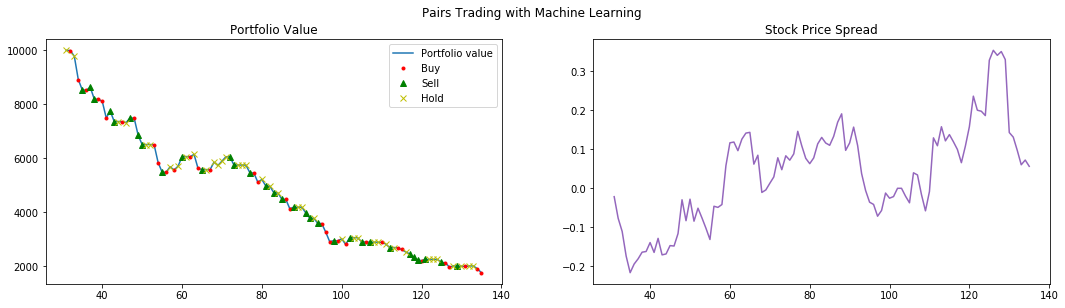

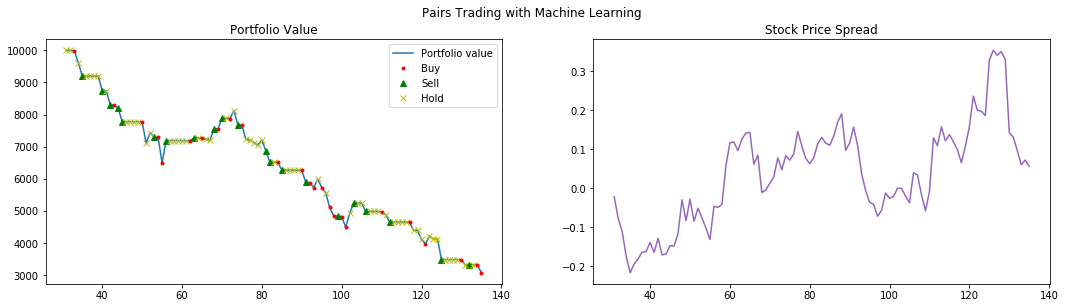

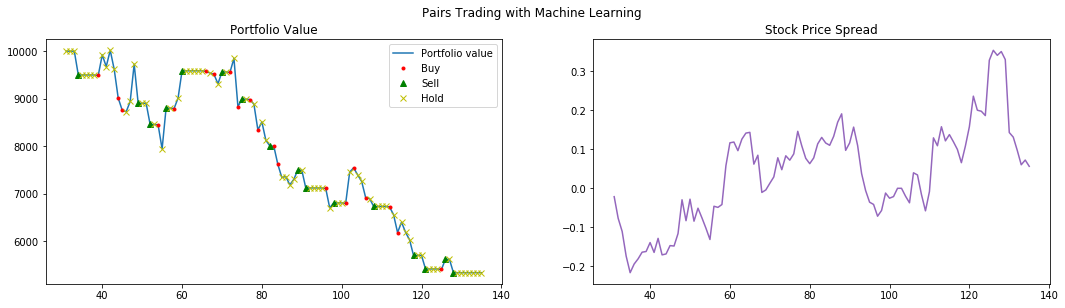

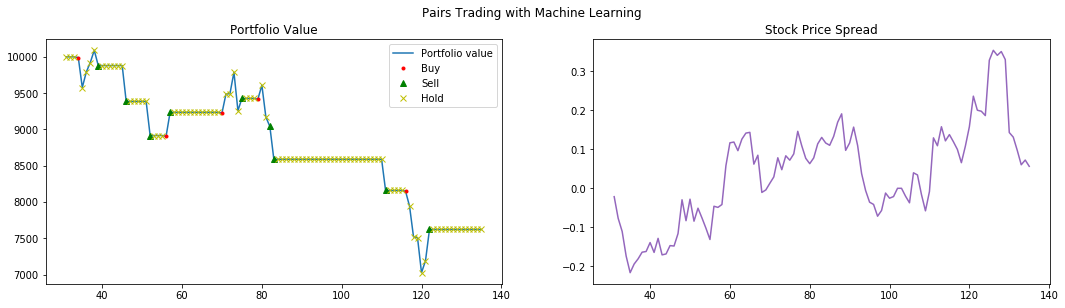

In [11]:
num_batches = np.random.randint(5, 15) # random number of batches
batch_size = np.random.randint(5, 15) # random batch size
num_epochs = 10 # 10 epochs to be used
penalty = 0.95 # we do not penalize illegal moves

trainModel(num_batches, batch_size, num_epochs, penalty, env2, model_v2)

### Model 2 testing

Environments are set.
Then, testing is performed against the random strategy.

In [16]:
env2_model = PairsTradingEnv("AAPL", "MSFT", 1, 1)
env2_random = PairsTradingEnv("AAPL","MSFT", 1, 1)

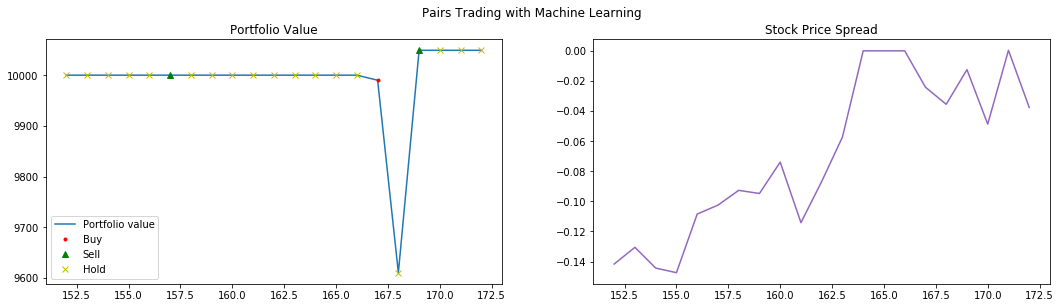

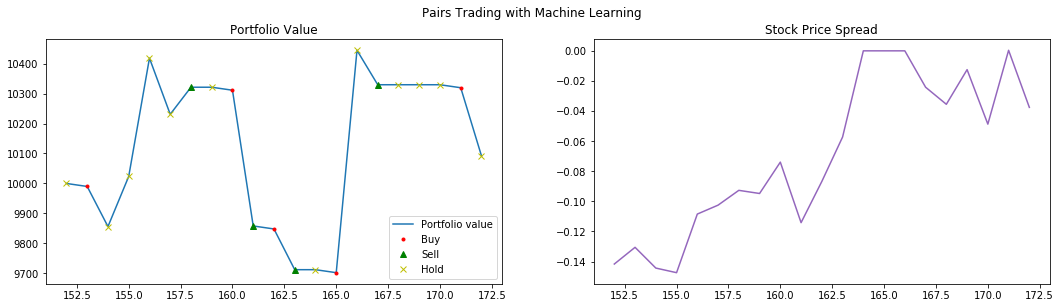

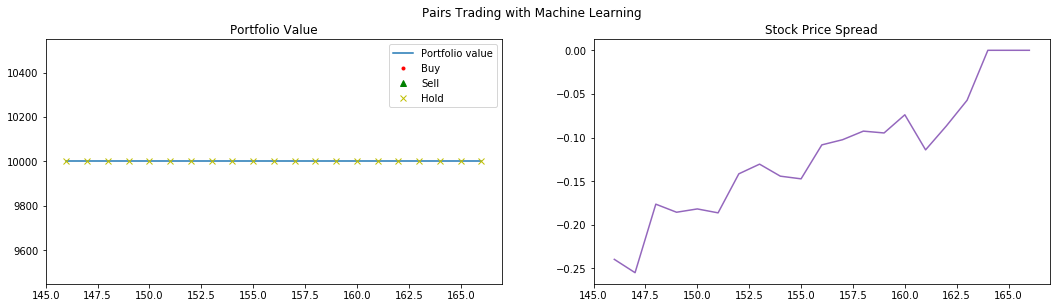

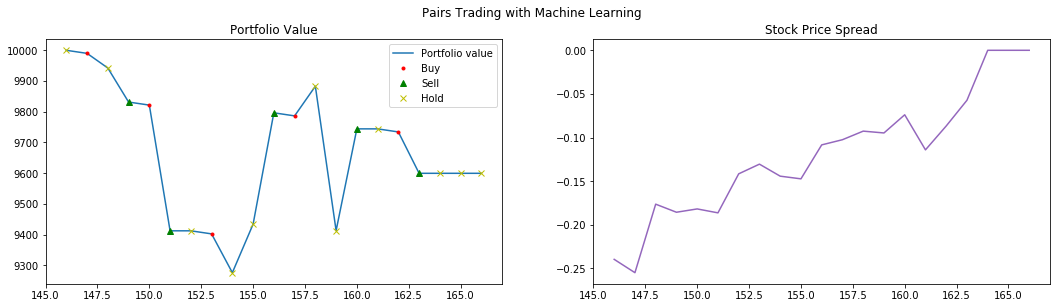

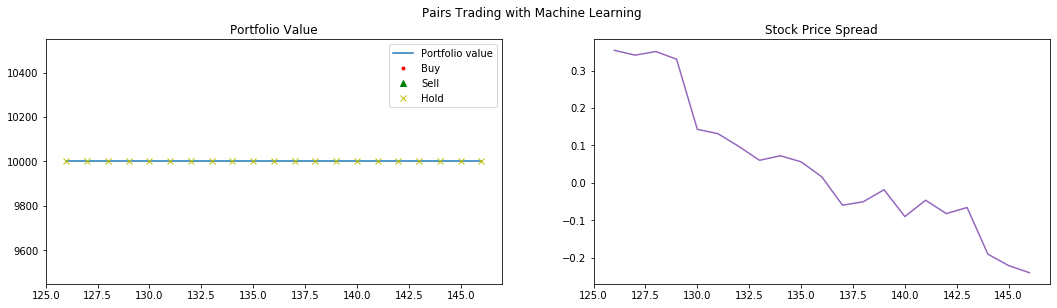

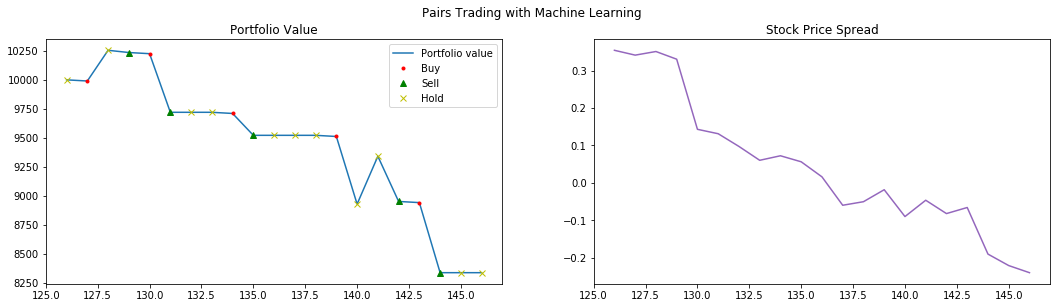

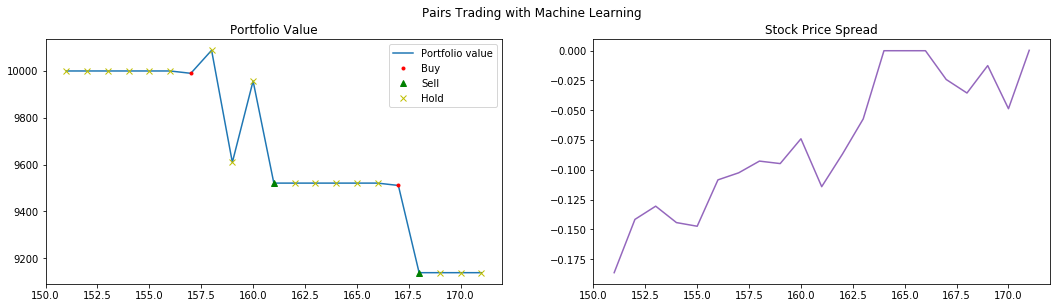

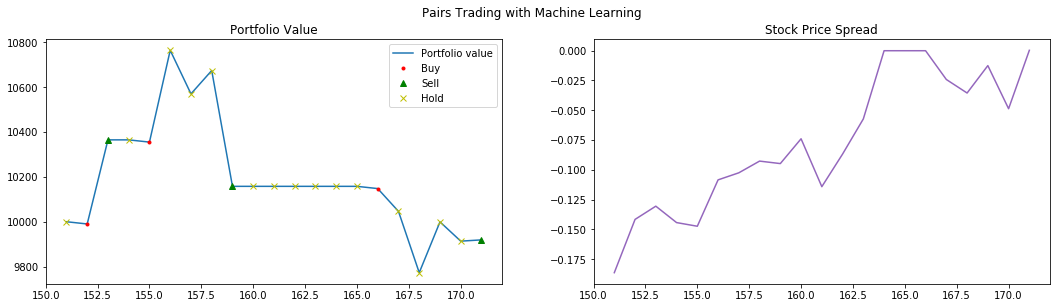

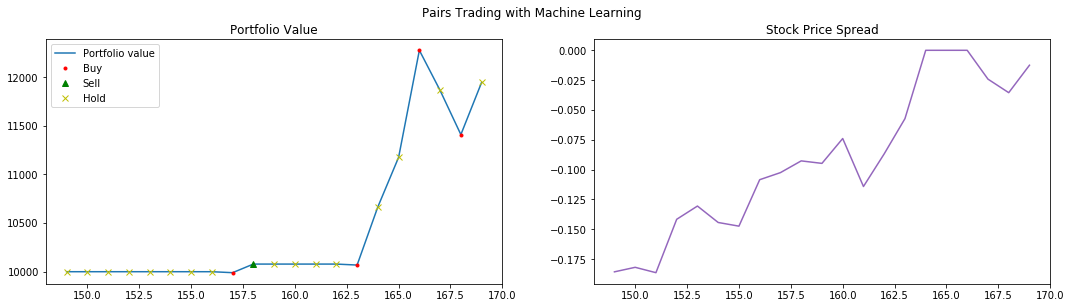

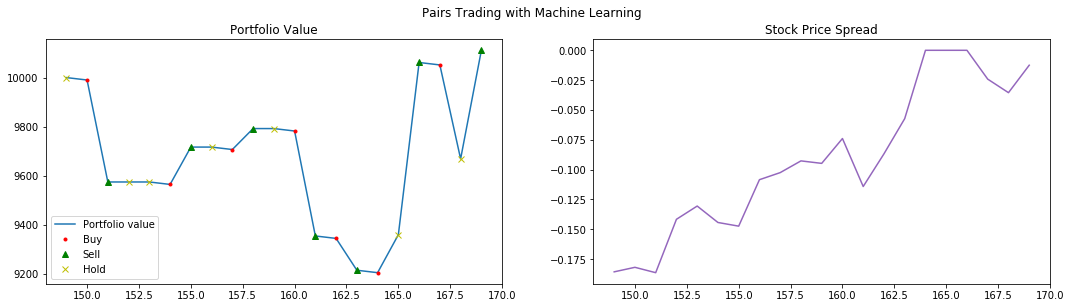

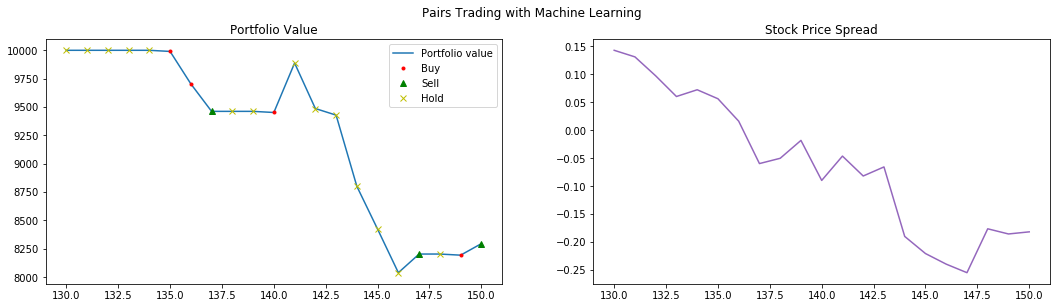

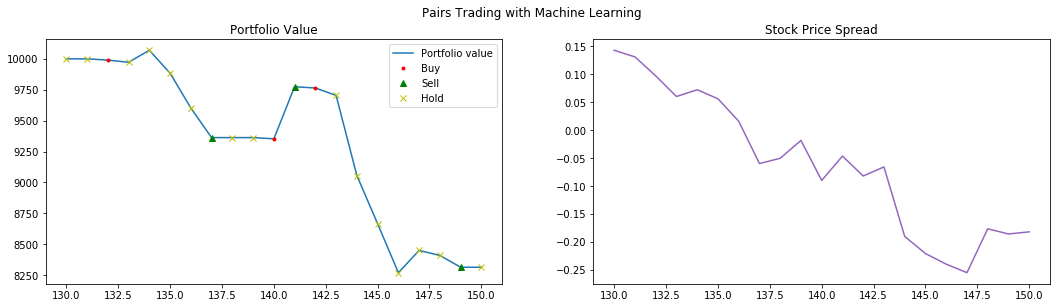

Model has: $10131.802800000001
Random Agent has: $9909.650233333336

Model has: $222.15256666666573 more than the Random Agent.


In [17]:
(model_reward, random_reward) = testModel(num_runs, length_run, start_day, env2_model, env2_random, model_v2)
print("Model has: $" + str(model_reward))
print("Random Agent has: $" + str(random_reward))
print()
print("Model has: $" + str(model_reward - random_reward) + " more than the Random Agent.")

### Model 2 Results

It turns out that the convergence described earlier may not be optimal. In this test run:

Model has: 10131.802800000001 dollars

Random Agent has: 9909.650233333336 dollars

Model has: 222.15256666666573 dollars more than the Random Agent.


While Model 2 outperformed Model 1, it may be possible to improve upon this behaviour through the use of other strategies.
Hence Model 3 has been introduced.

## Model 3

Only choosing a 1-day window for stock price changes may not allow the network to estimate when to buy, sell or hold the spread at the correct times.
Hence, the last 5 days of stock will be presented to the `Actor` and the `Critic`.

Additionally, an observation of whether or not the spread inverts has been added. This corresponds to the `spread_status = 2` argument in the `PairsTradingEnv`.

In [3]:
env3 = PairsTradingEnv("AAPL", "MSFT", 5, 2)
print(env3.observation_space.shape)

(13,)


Notice that the observation space is now significantly larger. Some changes have been made to the `Actor` and `Critic` also:

- Instead of using the standard Keras MSE loss function, a different implementation of MSE has been applied for the `Critic`.
- Dropout has been added in order to converge more slowly and hence add regularization.
- Tanh activation has been added in the input layers for both models in order to detect sensitivities in daily stock changes.
- Loss functions have been scaled up by 100 in order to emphasize otherwise small differences between predicted values of the reward and the action values.
- Penalty was applied only to the actor loss, instead of to the environment while training. This was due to a fear that the `Critic` becomes too pessimistic and evaluates all states as negative.

In [18]:
from tensorflow.keras.models import Sequential, Model

class ActorCritic_V3(object):
    """Improved ActorCritic model for continous observation space, and discrete action space
    
    Arguments:
        object {PairsTradingEnv} -- the pairs trading environment.
    
    Returns:
        model {ActorCritic_V1} -- the Keras model.
    """
    def __init__(self, env, **kwargs):
        """Initializes the model.
        
        Arguments:
            env {PairsTradingEnv} -- the pairs trading environment.
        
        Key Word Arguments:
            learning_rate {float} -- the learning rate.
        """
        self.env=env

        self.learning_rate = kwargs.get('learning_rate', 0.005)
        self.gamma = kwargs.get('gamma', 0.99)
    
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []
        self.penalty = []
        
        self.actor_model  = self._create_actor_model()
        self.critic_model = self._create_critic_model()

    def _create_actor_model(self):
        """Initializes the actor model.
        
        Returns:
            model {tf.keras.Sequential} -- the Actor model.
        """
        model = tf.keras.Sequential([
            # using tanh instead of relu for input
            kl.Dense(48, activation='tanh', input_shape=self.env.observation_space.shape),
            kl.Dropout(0.2), # dropout
            kl.Dense(128, activation='relu'),
            kl.Dropout(0.2), # dropout
            kl.Dense(self.env.action_space.n, activation='softmax', name='policy_logits')
        ])
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss=self._actor_loss(), optimizer=opt)
        return model

    def _create_critic_model(self):
        """Initializes the critic model.
        
        Returns:
            model {tf.keras.Sequential} -- the Critic model.
        """
        model = tf.keras.Sequential([
            # using tanh instead of relu for input
            kl.Dense(48, activation='tanh', input_shape=self.env.observation_space.shape),
            kl.Dropout(0.2),
            kl.Dense(128, activation='relu'),
            kl.Dropout(0.2),
            kl.Dense(1)
        ])
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss=self._critic_loss(), optimizer=opt)

        return model

    def evaluate_loss_actor(self, y_true, y_pred):
        """A custom loss function to evaluate loss for the actor.
        
        Arguments:
            y_true {list} -- the true label, in which the advantages and actions are embedded.
            y_pred {list} -- the model's predicted label.
        
        Returns:
            loss {Tensor} -- the actor's loss.
        """
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=False)
        advantages = y_true[:,0]
        actions = tf.cast(y_true[:,1], tf.int32)
        loss = 100*weighted_sparse_ce(actions, y_pred, sample_weight = advantages)
        return loss
    
    def _actor_loss(self):
        """A wrapper for the custom loss function for the actor.
        
        Returns:
            loss {Function} -- the custom loss function.
        """
        def loss(y_true,y_pred):
            return self.evaluate_loss_actor(y_true, y_pred)
        return loss

    
    def evaluate_MSE_loss_critic(self, y_true, y_pred): #smooth l1 loss
        """A custom loss function to evaluate loss for the critic.
        Smooth L1 loss.
        
        Arguments:
            y_true {list} -- the true label.
            y_pred {list} -- the model's predicted label.
        
        Returns:
            loss {Tensor} -- the critic's loss.
        """
        return kls.mean_squared_error(y_true*100, y_pred*100)
    
    
    def _critic_loss(self):
        """A wrapper for the custom loss function for the critic.
        
        Returns:
            loss {Function} -- the custom loss function.
        """
        def loss(y_true,y_pred):
            return self.evaluate_MSE_loss_critic(y_true, y_pred)
        return loss

    def train(self, obs_history):
        """The training loop for both the Actor and the Critic model.
        
        Arguments:
            obs_history {list} -- a list of observations for the required batch size.
        """
        advantages = np.array(self.rewards) - np.array(self.saved_values) - np.array(self.penalty)
        advantages= advantages*100
        y_label = []
        for adv, action in zip(advantages, np.array(self.saved_actions)):
            y_label.append([adv,action,0])
        
        y_label = np.array(y_label)
        self.actor_model.train_on_batch(np.array(obs_history), y_label)
        self.critic_model.train_on_batch(np.array(obs_history), self.rewards)
        
    
    def eval_state(self, obs):
        """Perform a prediction of the current state with the Critic.
        
        Arguments:
            obs {list} -- the current observation from the environment.
            
        Returns:
            estimated_reward {float} -- the reward of the current state that the Critic estimates.
        """
        return self.critic_model.predict(obs[None, :])
    
    
    def predict_action(self, obs):
        """Perform a prediction of the current state with the Actor.
        
        Arguments:
            obs {list} -- the current observation from the environment.
            
        Returns:
            probabilities {list} -- a probability distribution corresponding to the likelihood
            that each action should be selected.
            Example:
                [0.4, 0.5, 0.1]
                corresponds to:
                Choose action 0 (Buy) with probability 0.4
                Choose action 1 (Sell) with probability 0.5
                Choose action 2 (Hold) with probability 0.1
            Note that probabilities[0] is returned in order to reshape the network output.
                
        """
        logits = self.actor_model.predict(obs[None, :])
        action = tf.squeeze(tf.random.categorical(logits, 1), axis=-1)
        return logits[0]
    
    
    def predict(self,obs):
        """Perform a prediction of both models. This is possible since both models take in the observation
        space in the input layer.
        
        Arguments:
            obs {list} -- the current observation from the environment.
        
        Returns:
            (estimated_reward {int}, probabilities {list}) -- estimated reward, and estimated distribution.
        """
        return self.eval_state(obs), self.predict_action(obs)
    
    
    def reset(self):
        """Reset all data used in a training batch."""
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []
        self.penalty = []

In [19]:
model_v3 = ActorCritic_V3(env3)
type(model_v3) is ActorCritic_V3

True

### Model 3 training

Using the same scheme as before, Model 2 is trained.
However, in order to stimulate new behaviour while training, it is trained on 10 different segments.
The meaning of `penalty` has changed to penalize the actor loss.

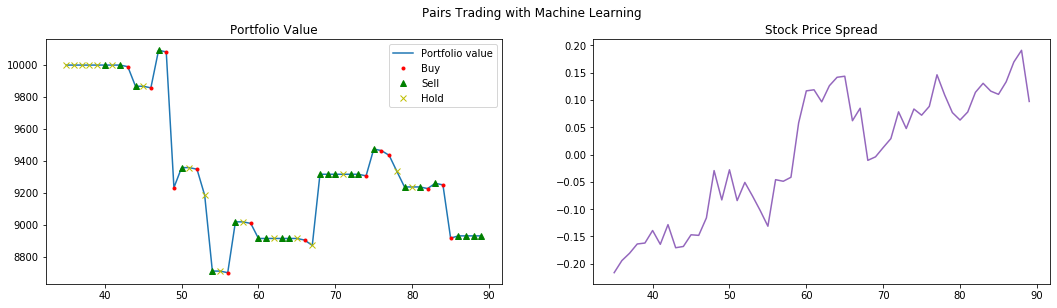

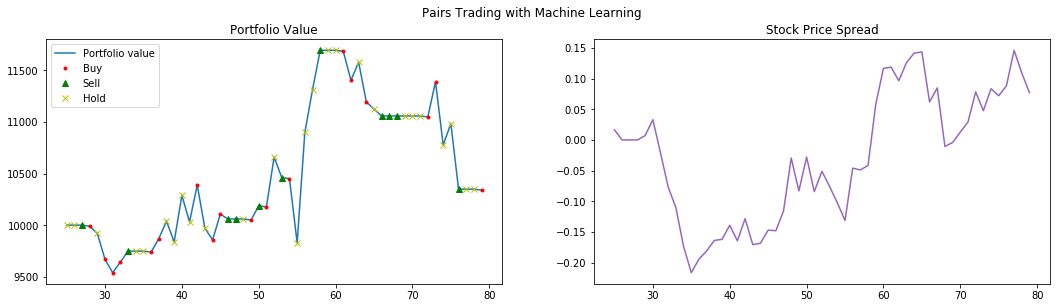

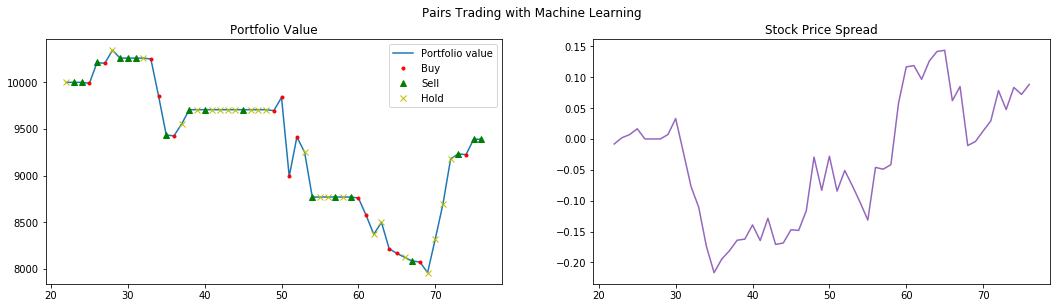

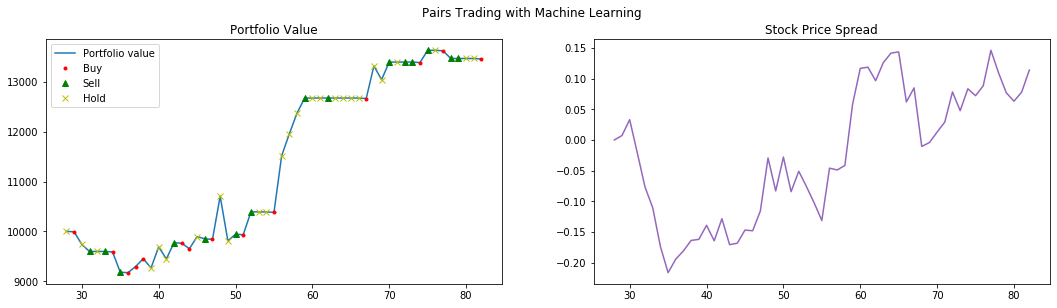

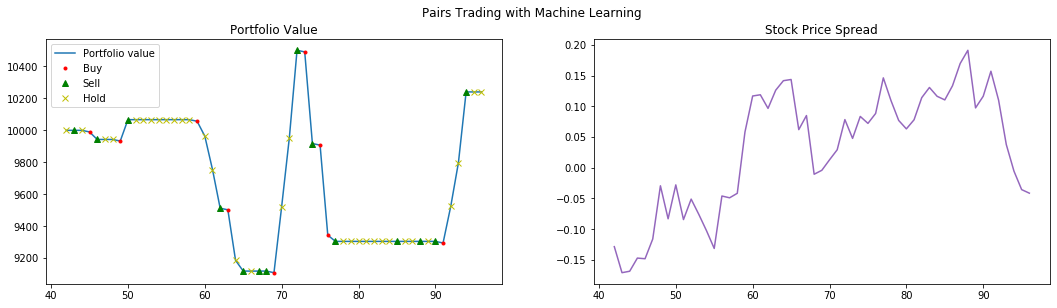

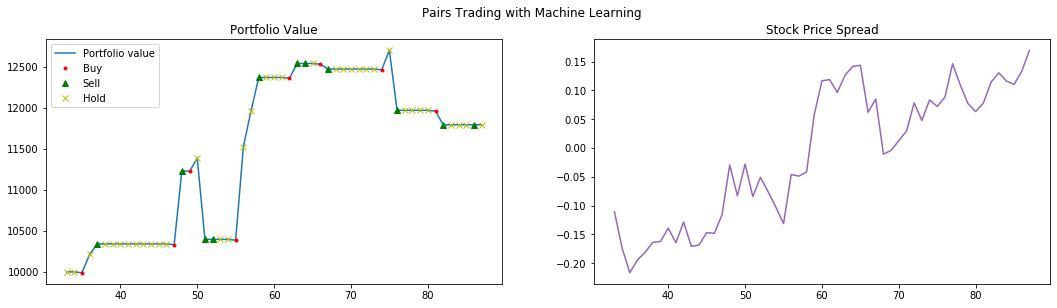

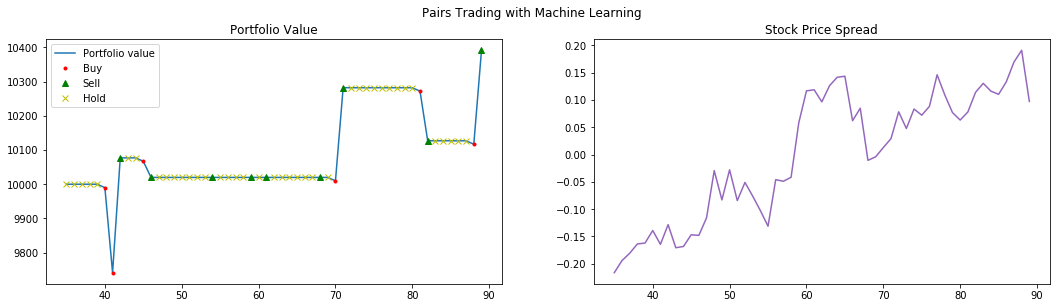

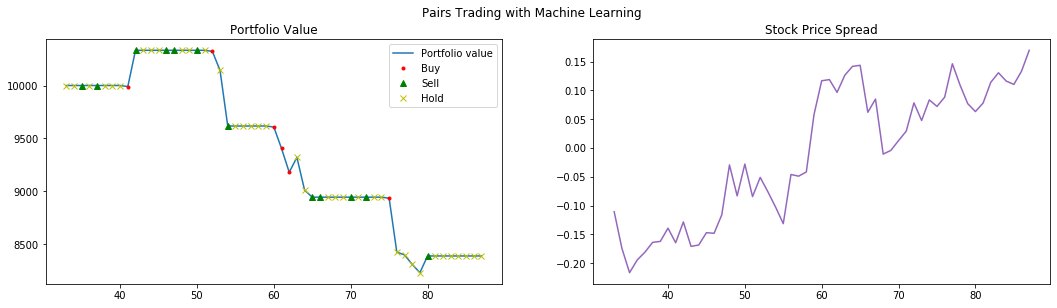

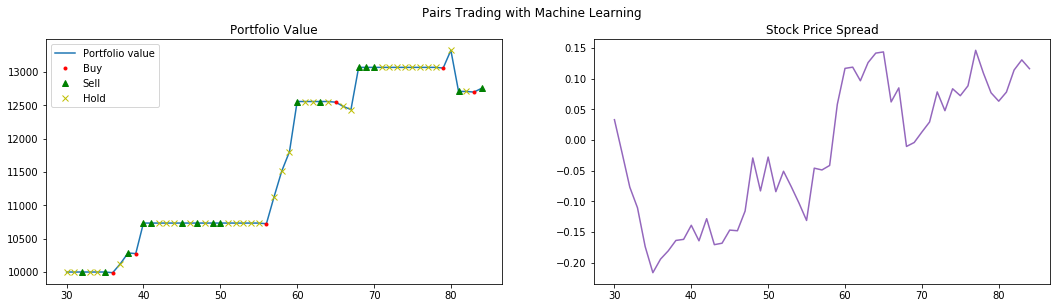

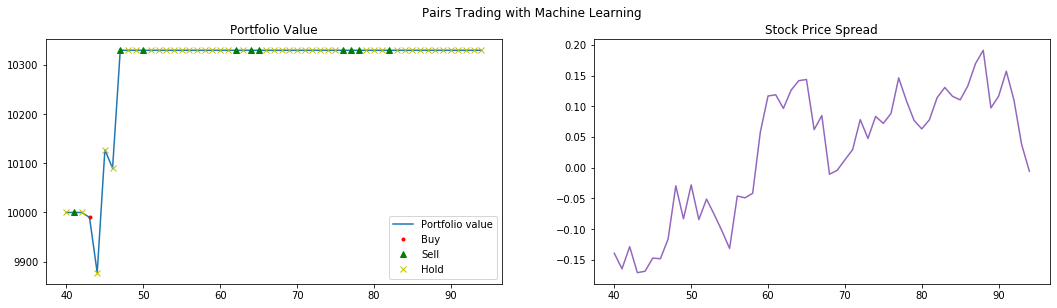

In [20]:
num_batches = np.random.randint(5, 15) # random number of batches
batch_size = np.random.randint(5, 15) # random batch size
num_epochs = 3 # 3 epochs to be used

penalty = 0.05 # the meaning of penalty has changed, see above

for ii in range(10):
    trainModel(num_batches, batch_size, num_epochs, penalty, env3, model_v3)

### Model 3 testing

Environments are set.
Then, testing is performed against the random strategy.

In [21]:
env3_model = PairsTradingEnv("AAPL", "MSFT", 5, 2)
env3_random = PairsTradingEnv("AAPL","MSFT", 5, 2)

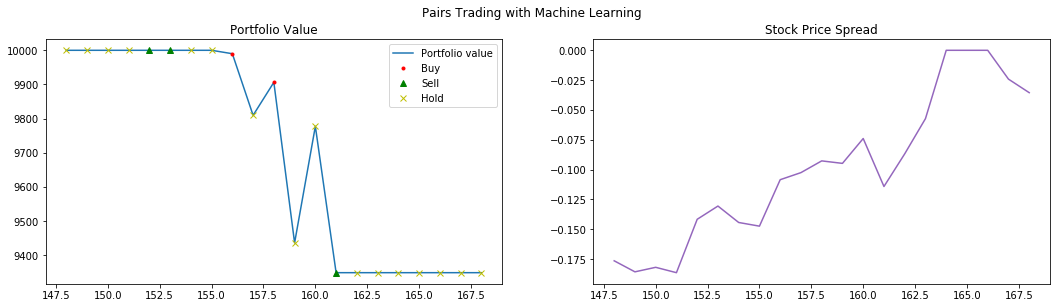

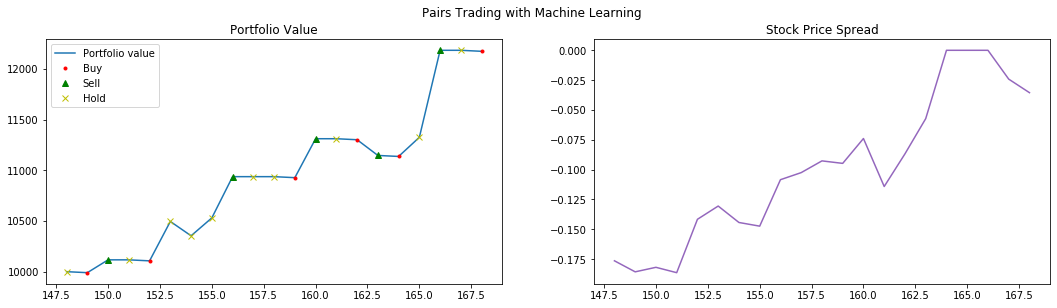

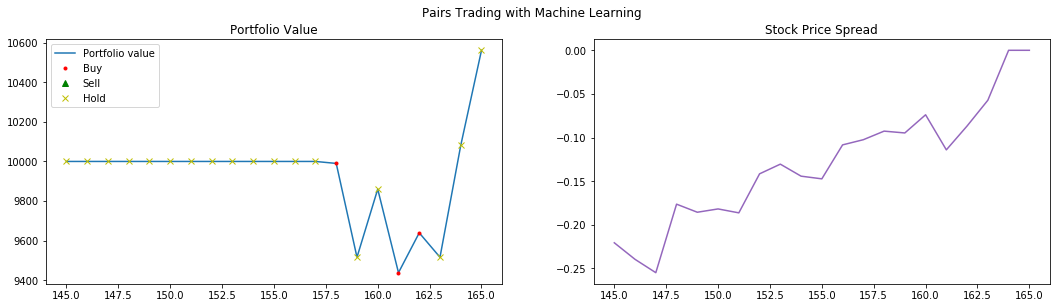

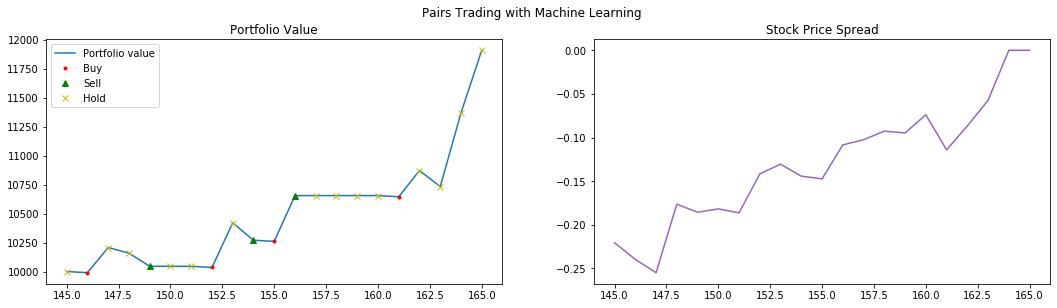

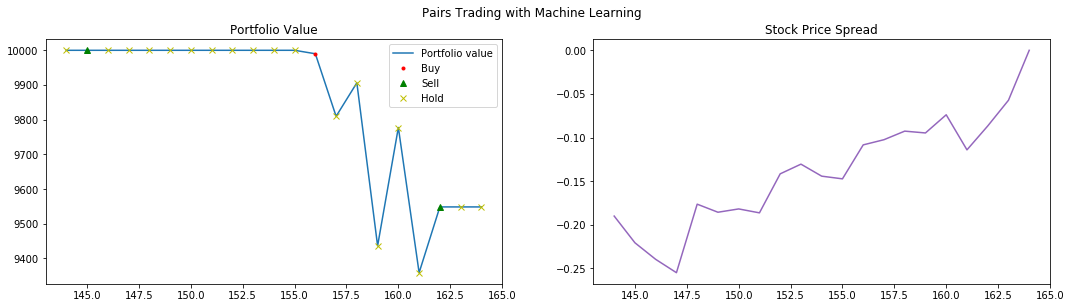

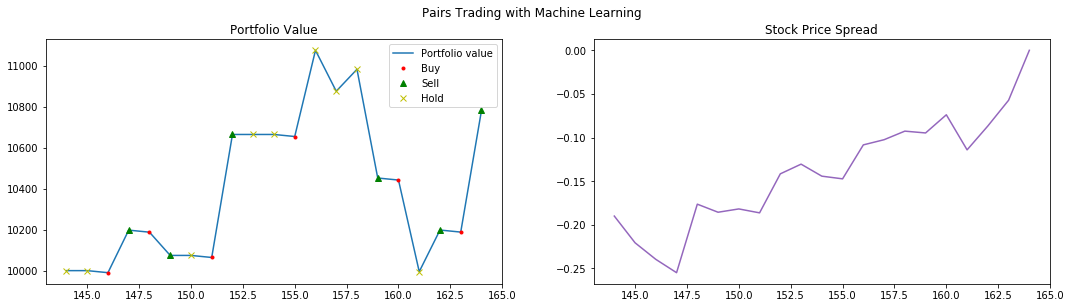

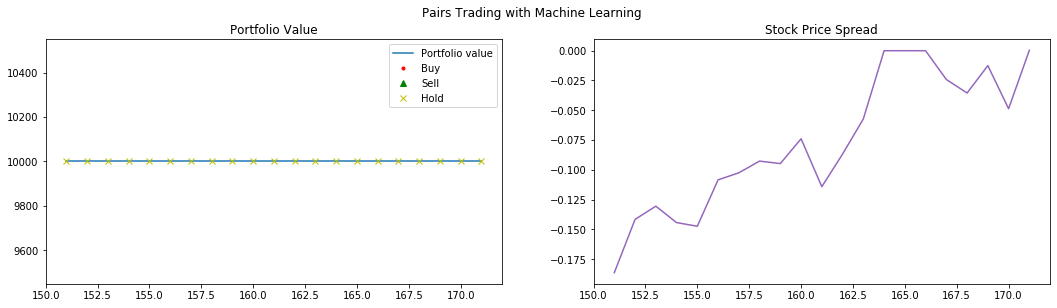

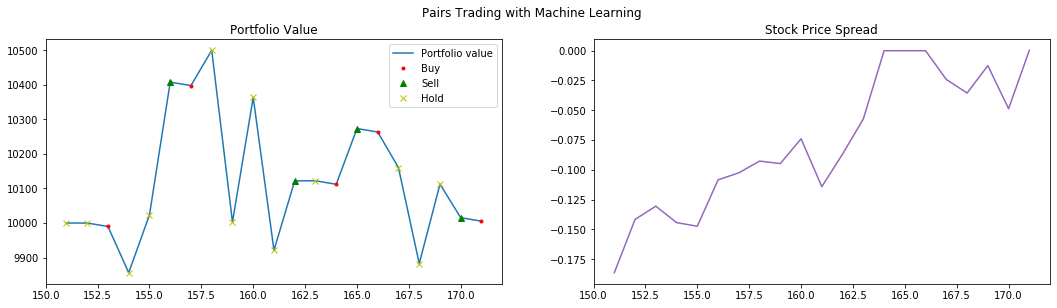

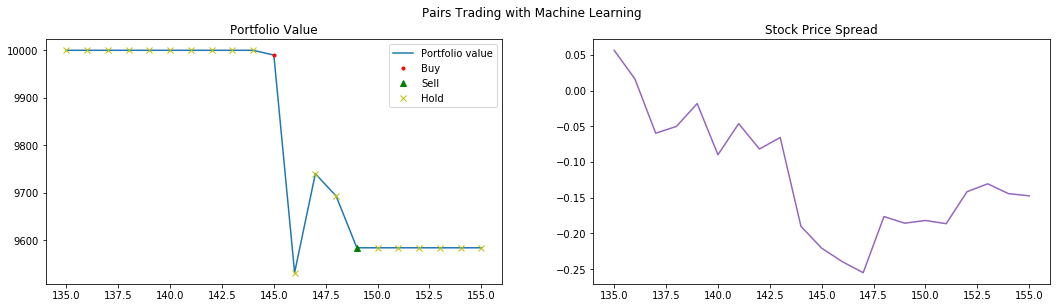

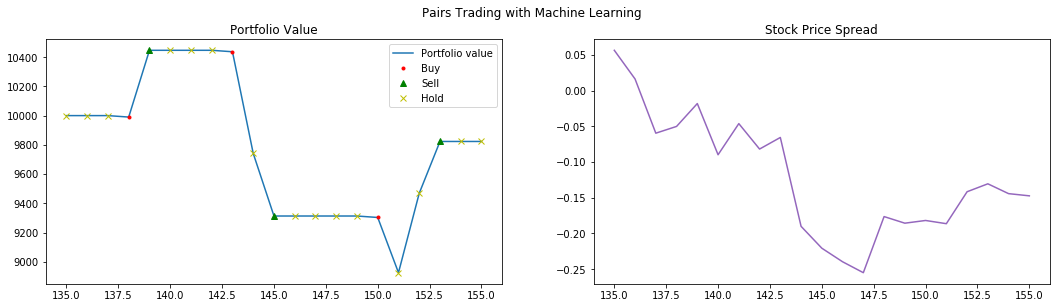

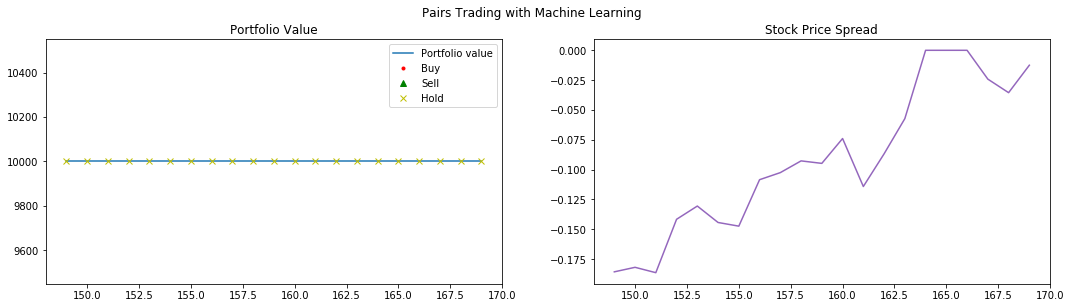

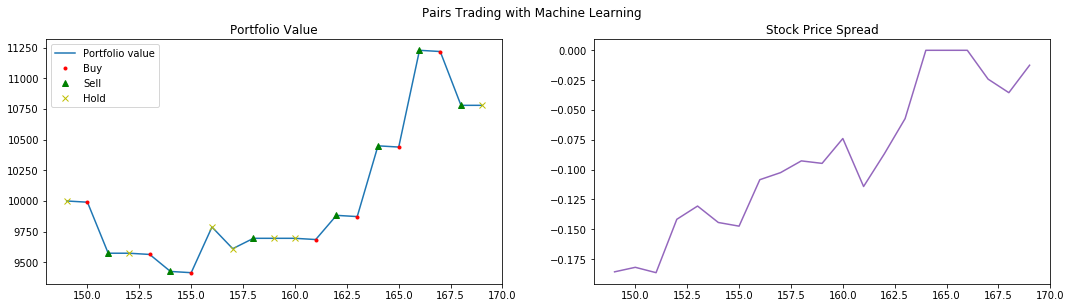

Model has: $9897.758366666667
Random Agent has: $9821.712833333333

Model has: $76.04553333333388 more than the Random Agent.


In [22]:
(model_reward, random_reward) = testModel(num_runs, length_run, start_day, env2_model, env2_random, model_v2)
print("Model has: $" + str(model_reward))
print("Random Agent has: $" + str(random_reward))
print()
print("Model has: $" + str(model_reward - random_reward) + " more than the Random Agent.")

## Conclusions

All models seem to consistently outperform a random strategy. However the hierarchy between the models is difficult to ascertain due to the inherent randomness in the tasks.

Based on these results, it seems like there may not be a significant advantage to using these networks in order to perform pairs trading. It may potentially be better to use an RNN due to the ability to model time dependencies due to their memory capacity. 